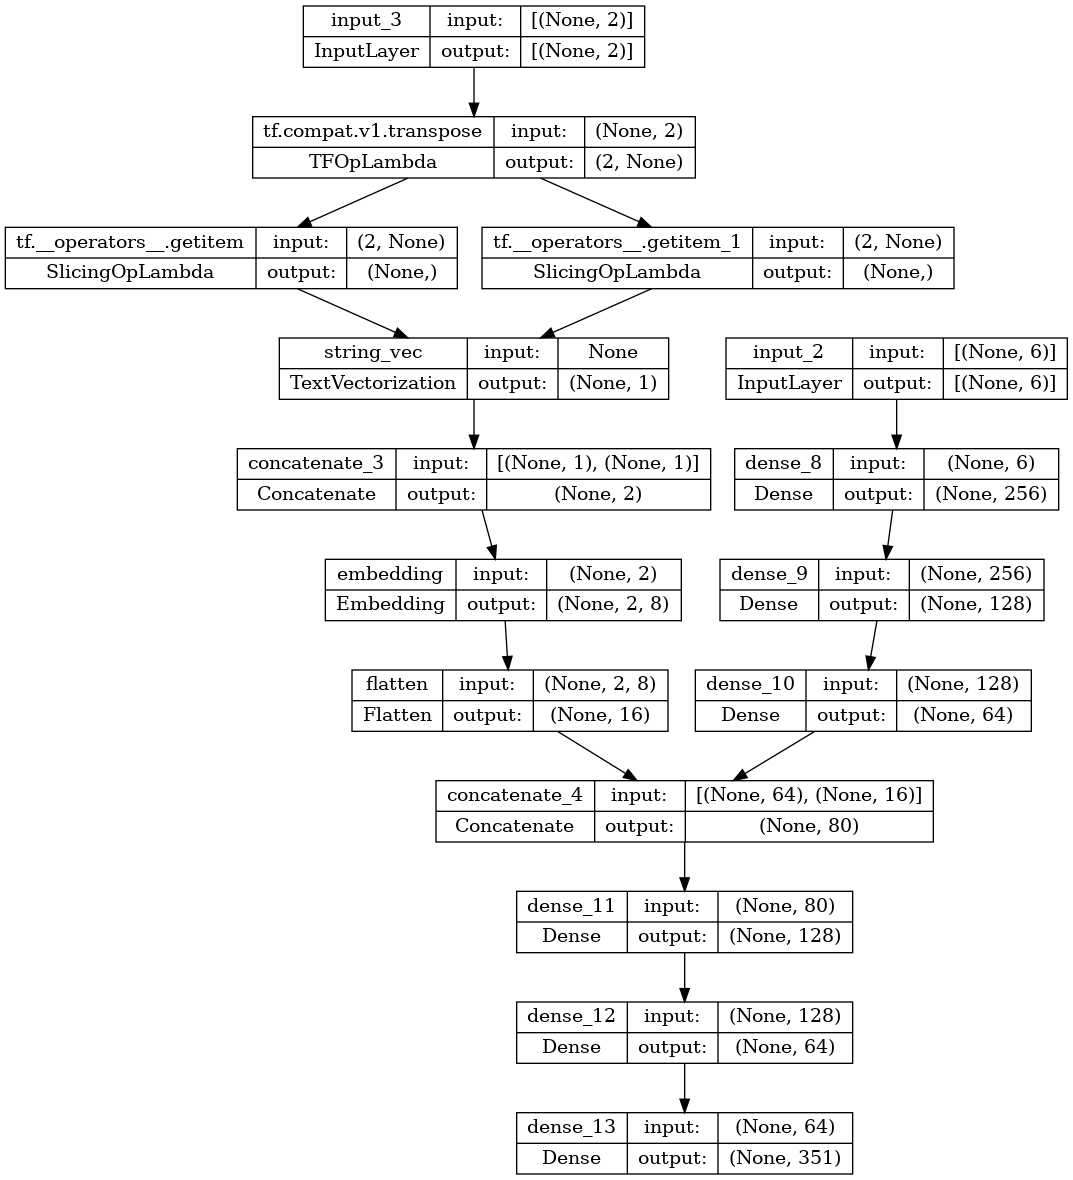

In [4]:
from tmm_ml_models import ForwardTMMModel
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt
import random
import numpy as np

training_data = pd.read_csv("R.csv")  # Read in the training data and split it into training and testing data

data_train, data_test = train_test_split(training_data, test_size=0.1)

model = ForwardTMMModel(serialised_model_path="forward_model.mdlsav")  # if the directory at `serialised_model_path` exists, and contains a saved keras model, then it will be loaded. Otherwise, model.is_trained will be set to false and training will be done in the cell below
plot_model(model.model, "forward_model.png", show_shapes=True)


In [3]:
feature_cols = ["d1", "d2", "d3", "d4", "d5", "d6", "First Layer", "Second Layer"]
if not model.is_trained:
    history = model.train(data_train[feature_cols], data_train[[c for c in data_train.columns if c not in feature_cols]], epochs=10)

In [ ]:
# Allows model to be saved to disk

answer = input("Would you like to save the trained model? (Y/N)")

match answer:
    case "Y":
        model.save()
    case other:
        print("Model not saved")


1/1 [==============================] - 0s 24ms/step


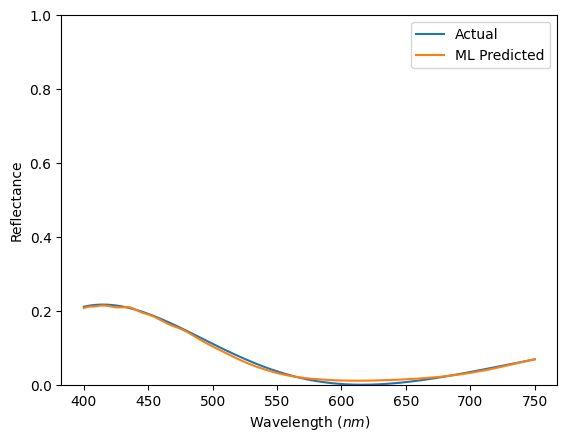

In [25]:
# Select a random index from the test set
index = random.randint(0, len(data_test[feature_cols]) - 1)

# Get the corresponding input and output values
input_sample = data_test[feature_cols].iloc[[index]]
output_sample = data_test[[c for c in data_test.columns if c not in feature_cols]].iloc[[index]]

# Make a prediction for the selected sample
prediction = model.predict(input_sample)
output_sample = np.squeeze(output_sample)
prediction = np.squeeze(prediction)
fig,ax = plt.subplots()
x = np.arange(400,751)
ax.plot(x, output_sample, label='Actual')
ax.plot(x, prediction, label='ML Predicted')
ax.set_ylim(0,1)
ax.legend()
ax.set_xlabel("Wavelength ($nm$)")
ax.set_ylabel("Reflectance")
plt.show()

In [11]:
input_sample

,d1,d2,d3,d4,d5,d6,First Layer,Second Layer
2691,20,60,20,50,30,50,Ag,PMMA
